In [35]:
import os
import pickle
import numpy as np
import torch
import sys
sys.path.append('../inverse_rendering/')
machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import redner
import pyredner
print(pyredner.__file__)
pyredner.render_pytorch.print_timing = False
import cv2
from general_imports import *

/net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [ ]:
import torch
from tfrecord.torch.dataset import TFRecordDataset

tfrecord_folder = "/om/user/xboix/da"

In [ ]:
all_tfs = os.listdir('')

In [36]:
with open('../training_models/shapenet_class_num_to_class_name.p','rb') as F:
    shapenet_class_num_to_class_name = pickle.load(F)
with open('../training_models/shapenet_id_to_class_num.p','rb') as F:
    shapenet_id_to_class_num = pickle.load(F)

In [37]:
model_path = '../training_models/saved_models/resnet18_v7_places_normalized.pt'
loaded_model = torch.load(model_path)
softmax_layer = nn.Softmax()

In [38]:
def clone_scene_params(scene_params):
    original_scene_params = [0,0,0,0]
    original_scene_params[0] = scene_params[0]

    original_scene_params[1] = {}
    for key in scene_params[1].keys():
        original_scene_params[1][key] = scene_params[1][key].clone()

    original_scene_params[2] = {}
    for key in scene_params[2].keys():
        original_scene_params[2][key] = [i.clone() for i in scene_params[2][key]]

    original_scene_params[3] = scene_params[3]
    return original_scene_params

def start_up(scene_params, optimized_params):
    model_file, camera_params, light_params, material_settings = scene_params
    variables = []
    var_names_list = []
    for param in optimized_params:
        if param in camera_params.keys():
            optimize_flags(camera_params[param])
            if type(camera_params[param]) == list:
                variables.extend(camera_params[param])
            else:
                variables.append(camera_params[param])
        elif param in light_params.keys():
            optimize_flags(light_params[param])
            if type(light_params[param]) == list:
                variables.extend(light_params[param])
            else:
                variables.append(light_params[param])

    scene_params = [model_file, camera_params, light_params, material_settings]
    scene = setup_scene(scene_params)

    return scene, variables

def load_geometry(model_file, geometry, mat):
    if geometry:
        obj_model_all = model_file
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    else:
        obj_model_all = pyredner.load_obj(model_file, return_objects=True)
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]

    for part in obj_model:
        part.material = mat

    return obj_model
def get_random_crop(im_array):
    h,w,c = im_array.shape
    random_w = 10
    random_h = 10
    random_crop = im_array[random_h:random_h+224, random_w:random_w+224, :]

    return random_crop

def augment_image(places_path, shapenet_array, shapenet_mask):
    shapenet_mask = shapenet_mask.astype('uint8')

    fg = cv2.bitwise_or(shapenet_array, shapenet_array, mask=shapenet_mask)
    
    
    bg_array = np.array(Image.open(places_path).convert('RGB'))
    bg_random = get_random_crop(bg_array)
    
    bg_mask = (cv2.bitwise_not(shapenet_mask)/255).astype('uint8')

    bk = cv2.bitwise_or(bg_random, bg_random, mask=bg_mask)

    final = cv2.bitwise_or(fg, bk)
    return final

def render_input(scene, places_path):
    num_lights = len(scene.area_lights)
#     print('num lights is %s'%num_lights)
    ### Mask Rendering ###
    rendered_channels = [pyredner.channels.shape_id]
    img_mask = pyredner.render_generic(scene,channels = rendered_channels, num_samples = 1024)
    shape_id_arr = np.array(img_mask.detach().cpu())[:,:,0]
    
    ### Pathtracing Rendering ###
    img = pyredner.render_pathtracing(scene = scene, num_samples = 256, seed = 1, use_secondary_edge_sampling = False)
    img = torch.clamp(img, min = 0.00000001)
    img = torch.pow(img, 1.0/2.2)
    img = img*255/torch.max(img)
    inputs_arr = np.array(img.cpu()).astype('uint8')
    
    ##### Merge on places image ####
    augmented = augment_image(places_path, inputs_arr, shape_id_arr).astype('float32')
    augmented_ = torch.from_numpy(augmented)    
    inputs = augmented_.permute(2,0,1).unsqueeze(0)
    return inputs


def setup_scene(scene_params):

    model_file, camera_params, light_params, material_settings = scene_params
    obj_model = load_geometry(model_file, False, material_settings['diffuse_material'])

    #### Camera Setup ####
    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224),
                                                   fov = torch.tensor([camera_params['fov']]),
                                                   up = camera_params['cam_up'],
                                                   look_at = camera_params['cam_look_at'])
    scene_cam.position = camera_params['camera_position']

    #### Lights Setup ####
    scene_lights = []
    num_lights = len(light_params['all_light_positions'])
    for i in range(num_lights):
        scene_light = pyredner.generate_quad_light(position = light_params['all_light_positions'][i],
                                     look_at = light_params['all_light_look_ats'][i],
                                     size = light_params['all_light_sizes'][i],
                                     intensity = light_params['all_light_intensities'][i],
                                     directly_visible = False)
        scene_lights.append(scene_light)

    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)

    return scene

def show_inputs(inp, save_path = False, title='No Title'):
    plt.imshow(inp[0].cpu().permute(1,2,0).int())
    plt.title(title)
    plt.axis('off')
    if save_path != False:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [39]:
varying_camera = True
varying_light = False

In [40]:
def evaluate_exp(exp_path, render = False, show = False):
    with open(exp_path, 'rb') as F:
        exp_info = pickle.load(F)
    
    starting_scene_params = exp_info['scene_params']
    all_predictions = exp_info['es'].predictions
    all_prediction_settings = exp_info['es'].prediction_settings
    correct_prediction = exp_info['es'].correct_prediction

    ids = np.where(np.array(all_predictions) != correct_prediction)
    
    if len(ids[0]) != 0:
        found_adv = True
        adv_predictions = np.array(all_predictions)[ids]
        adv_prediction_settings = np.array(all_prediction_settings)[ids]

        adv_id = random.choice(range(len(ids)))

        starting_scene_params = exp_info['scene_params']

        adv_scene_params = clone_scene_params(starting_scene_params)
        if varying_camera:
            adv_scene_params[1]['camera_position'] = torch.tensor(adv_prediction_settings[adv_id][:3]).float()
            adv_scene_params[1]['cam_look_at'] = torch.tensor(adv_prediction_settings[adv_id][3:6]).float()
            adv_scene_params[1]['cam_up'] = torch.tensor(adv_prediction_settings[adv_id][6:9]).float()
            adv_scene_params[1]['fov'] = torch.tensor(adv_prediction_settings[adv_id][9]*10).float()
        elif varying_light:
            num_lights = int(adv_prediction_settings[adv_id].shape[0]/11)
            adv_scene_params[2]['all_light_positions'] = torch.tensor(adv_prediction_settings[adv_id][:num_lights*3]).float().view(num_lights,-1)
            adv_scene_params[2]['all_light_look_ats'] = torch.tensor(adv_prediction_settings[adv_id][num_lights*3:num_lights*6]).float().view(num_lights,-1)
            adv_scene_params[2]['all_light_intensities'] = torch.tensor(adv_prediction_settings[adv_id][num_lights*6:num_lights*9]).float().view(num_lights,-1)
            adv_scene_params[2]['all_light_sizes'] = torch.tensor(adv_prediction_settings[adv_id][num_lights*9:]).float().view(num_lights,-1)
        params = [starting_scene_params, adv_scene_params]
    else:
        found_adv = False
        params = [starting_scene_params]

    inps = []
    predictions = []
    
    if render:
        print('Rendering')
        for i in range(len(params)):
            param = params[i]
            scene, variables = start_up(param, [])
            places_path = exp_info['places_background']
            inputs = render_input(scene, places_path)
            inputs = inputs.cuda()
            rendered_inputs = inputs.clone()
            inputs = inputs
            im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
            im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
            inputs_ = (inputs - im_means)/im_stds
            outputs = loaded_model(inputs_)
            probability = outputs[0][correct_prediction].item()
            prediction = torch.argmax(outputs[0]).item()
            predictions.append(prediction)
            inps.append(rendered_inputs)
        if len(inps) == 1:
            inps.append(inps[0])
            predictions.append(predictions[0])

    
    if show:
        print('Showing')
        fig,ax = plt.subplots(nrows=1,ncols=2)
        ax[0].imshow(inps[0][0].cpu().permute(1,2,0).int())
        ax[0].axis('off')
        ax[0].set_title('Starting: %s (%s)'%(shapenet_class_num_to_class_name[predictions[0]].split(',')[0], predictions[0]))
        ax[1].imshow(inps[1][0].cpu().permute(1,2,0).int())
        ax[1].axis('off')        
        ax[1].set_title('Ending: %s (%s)'%(shapenet_class_num_to_class_name[predictions[1]].split(',')[0], predictions[1]))
        plt.show()
        
    return found_adv, inps, predictions

In [41]:
def render_input_original(scene):
    img = pyredner.render_pathtracing(scene = scene, num_samples = 256, seed = 1, use_secondary_edge_sampling = False)
    img = torch.clamp(img, min = 0.00000001)
    img = torch.pow(img, 1.0/2.2)
    img = img*255/torch.max(img)
    inputs = img.permute(2,0,1).unsqueeze(0)
    return inputs

In [42]:
folder = '/om5/user/smadan/differentiable_graphics_ml/other_optimization_methods/cma_adversarial_cam/resnet18_v7_places/'

In [44]:
intermediates_folder = "%s/intermediates"%folder

In [46]:
intermediates = os.listdir(intermediates_folder)

In [55]:
correct_prediction = 9

In [57]:
# for im in intermediates:
#     if im.endswith('.t'):
#         rendered_input = torch.load('%s/%s'%(intermediates_folder, im))
#         inputs = rendered_input
#         im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
#         im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
#         inputs_ = (inputs - im_means)/im_stds
#         outputs = loaded_model(inputs_)
#         probability = outputs[0][correct_prediction].item()
#         prediction = torch.argmax(outputs[0]).item()
#         pred = im.split('_')[-2]
#         show_inputs(rendered_input, title = "Prediction: %s and %s"%(pred, prediction))

In [48]:
rendered_saved = torch.load('%s/1iNa3rCXPHYN4RdF_9_6.t'%intermediates_folder)

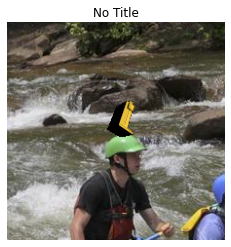

In [51]:
show_inputs(rendered_saved,)

In [9]:
save_folder = "%s/saved_images/"%folder

In [10]:
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)

In [11]:
exp = 'WUw8sGN4zlciffsd.p'
exp_p = "%s/%s"%(folder, exp)

In [17]:
with open(exp_p, 'rb') as F:
    exp_info = pickle.load(F)

In [18]:
# found_adv, rendered_inputs, predictions = evaluate_exp(exp_p, render = True, show = True)

In [14]:
# success_count = 0
# total = 0
# for exp in tqdm(os.listdir(folder)):
#     if '.p' in exp:
#         exp_p = "%s/%s"%(folder, exp)
# #         scene_random = evaluate_exp(exp_p, render = True, show = True)
#         found_adv, rendered_inputs, predictions = evaluate_exp(exp_p, render = True, show = True)
#         break
# #         starting_image_path = "%s/%s_starting_%s.png"%(save_folder, exp_p.split('/')[-1].split('.p')[0], predictions[0])
# #         show_inputs(rendered_inputs[0], save_path = starting_image_path)

#         if found_adv == True:
# #             adv_image_path = "%s/%s_adversarial_%s.png"%(save_folder, exp_p.split('/')[-1].split('.p')[0], predictions[1])
# #             show_inputs(rendered_inputs[1], save_path = adv_image_path)
#             success_count += 1
        
#         total += 1

In [25]:
adv_prediction_settings = exp_info['es'].prediction_settings
CATEGORY_NUM = exp_info['es'].correct_prediction

In [26]:
places_path = exp_info['places_background']

In [27]:
exp_info['es'].predictions

[9, 9, 9, 9, 9, 2, 2, 2, 9, 2]

num lights is 2


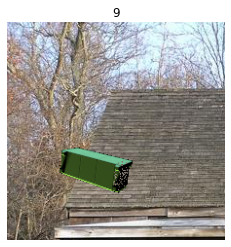

num lights is 2


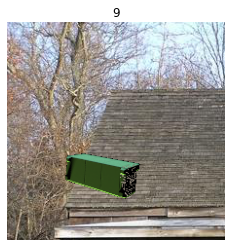

num lights is 2


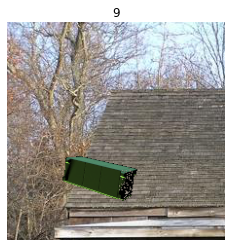

num lights is 2


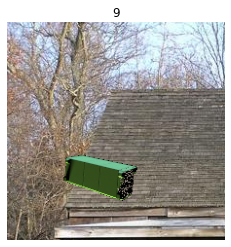

num lights is 2


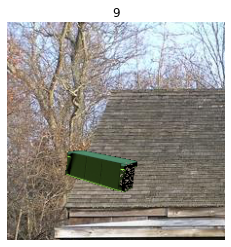

num lights is 2


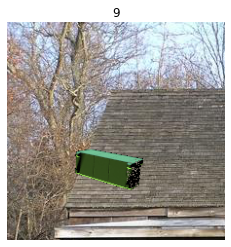

num lights is 2


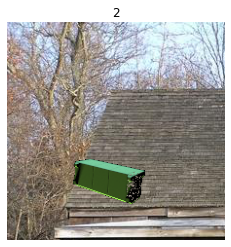

num lights is 2


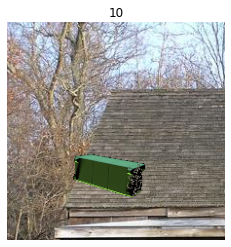

num lights is 2


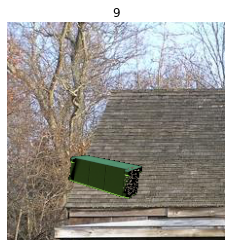

num lights is 2


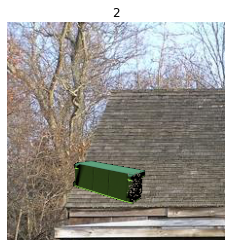

In [28]:
for i in range(10):
    adv_scene_params = clone_scene_params(exp_info['scene_params'])
    adv_scene_params[1]['camera_position'] = torch.tensor(adv_prediction_settings[i][:3]).float()
    adv_scene_params[1]['cam_look_at'] = torch.tensor(adv_prediction_settings[i][3:6]).float()
    adv_scene_params[1]['cam_up'] = torch.tensor(adv_prediction_settings[i][6:9]).float()
    adv_scene_params[1]['fov'] = torch.tensor(adv_prediction_settings[i][9]*10).float()
    
    scene, variables = start_up(adv_scene_params, [])
    inputs = render_input(scene, places_path)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = loaded_model(inputs_)
    probability = outputs[0][CATEGORY_NUM].item()
    prediction = torch.argmax(outputs[0]).item()
    show_inputs(inputs, title = prediction)